In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import astropy.units as u
import astropy.constants as cr
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt
import matplotlib
from astroduet.config import Telescope
from astroduet.filters import load_qe, load_reflectivity, load_redfilter, load_transmission, apply_trans
from astroduet.background import airglow_lines
from astroduet.background import background_pixel_rate
from astroduet.zodi import load_airglow, load_zodi

In [2]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = [15,8]
plotcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
duet = Telescope()
# Background spectrum
zodi = load_zodi(scale=77, airglow=False)
no_airglow = zodi['flux'].copy()
airglow_lines = airglow_lines(zodi['wavelength'])
zodi['flux'] += airglow_lines

# Medium and high zodi spectra
zodi_med = load_zodi(scale=165, airglow=False)
zodi_med['flux'] += airglow_lines
zodi_high = load_zodi(scale=900, airglow=False)
zodi_high['flux'] += airglow_lines

# Flat spectrum
flat = {'wavelength': zodi['wavelength'], 'flux': [1]*len(zodi['flux'])*zodi['flux'].unit}

# Load filters, transmission and stuff
ref_wave, reflectivity = load_reflectivity(duet.reflectivity_file['name'], diag=True)
trans_wave, transmission = load_transmission(duet.transmission_file)
pixel_area = duet.pixel **2
qe_wave1, qe1 = load_qe(duet.qe_files['names'][0])
qe_wave2, qe2 = load_qe(duet.qe_files['names'][1])
red_wave1, red_trans1 = load_redfilter(duet.bandpass_files['names'][0], filter_type='B')
red_wave2, red_trans2 = load_redfilter(duet.bandpass_files['names'][1], filter_type='B')

Optics reflectivity loader
Input file /Users/mheida/scripts/git/duet-astro/astroduet/data/mirror_coatings_20190518.csv


In [4]:
alt_wave2, alt_trans2 = red_wave2+10*u.nm, red_trans2

In [5]:
print(duet.band1)
print(duet.band2)

{'eff_wave': <Quantity 198.63858525 nm>, 'eff_width': <Quantity 31.00790249 nm>}
{'eff_wave': <Quantity 280.56077333 nm>, 'eff_width': <Quantity 51.25641246 nm>}


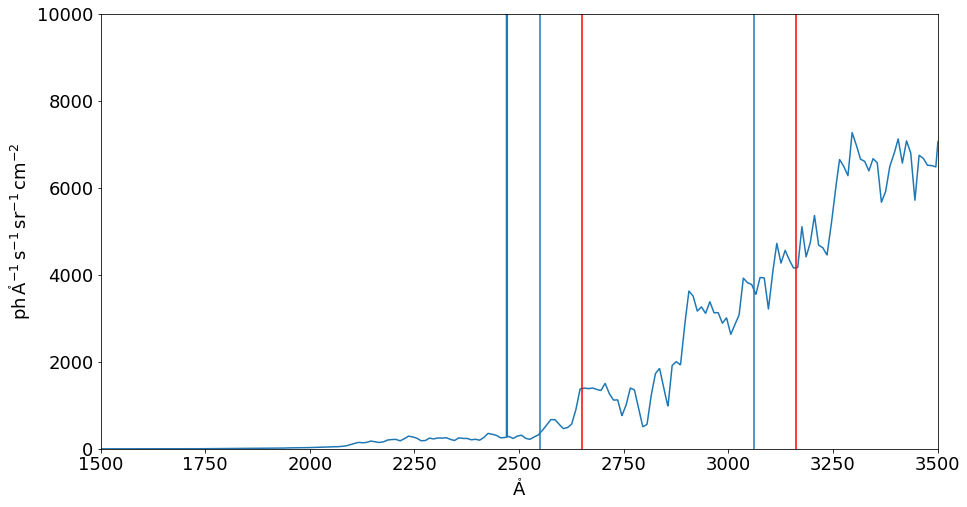

In [6]:
with quantity_support():
    plt.plot(zodi['wavelength'], zodi['flux'])
    plt.axvline(x=duet.bandpass2[0], ymin=0, ymax=1)
    plt.axvline(x=duet.bandpass2[1], ymin=0, ymax=1)
    plt.axvline(x=duet.bandpass2[0]+10*u.nm, ymin=0, ymax=1, color='red')
    plt.axvline(x=duet.bandpass2[1]+10*u.nm, ymin=0, ymax=1, color='red')    
    plt.ylim(0,1e4)
    plt.xlim(1500,3500)

In [7]:
flat['flux_t'] = apply_trans(flat['wavelength'], flat['flux'], trans_wave, transmission)
flat['flux_tr'] = apply_trans(flat['wavelength'], flat['flux_t'], ref_wave, reflectivity)
flat['flux_trq'] = apply_trans(flat['wavelength'], flat['flux_tr'], qe_wave1, qe1)
flat['flux_trqf'] = apply_trans(flat['wavelength'], flat['flux_trq'], red_wave1, red_trans1)

flat['flux_trq2'] = apply_trans(flat['wavelength'], flat['flux_tr'], qe_wave2, qe2)
flat['flux_trqf2'] = apply_trans(flat['wavelength'], flat['flux_trq2'], red_wave2, red_trans2)

flat['flux_trqf2alt'] = apply_trans(flat['wavelength'], flat['flux_trq2'], alt_wave2, alt_trans2)

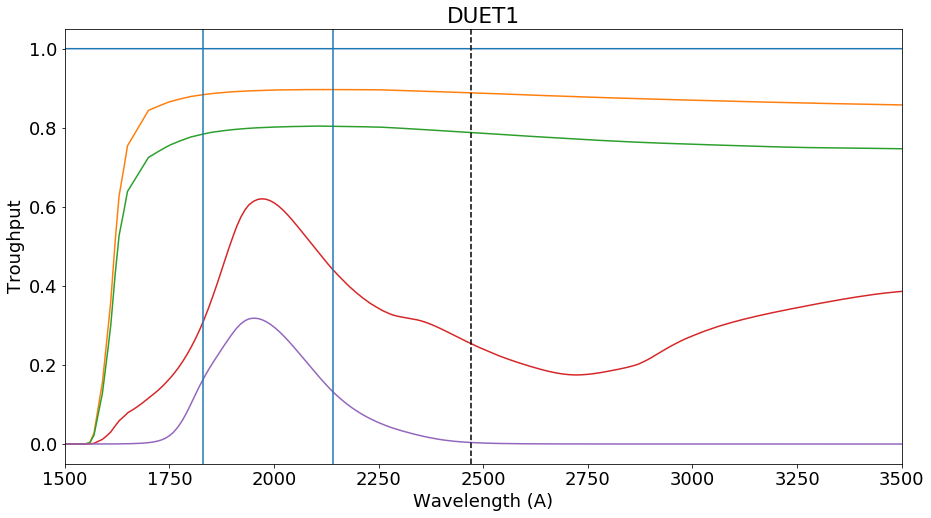

In [42]:
with quantity_support():
    plt.plot(flat['wavelength'], flat['flux'])
    plt.plot(flat['wavelength'], flat['flux_t'])
    plt.plot(flat['wavelength'], flat['flux_tr'])
    plt.plot(flat['wavelength'], flat['flux_trq'])
    plt.plot(flat['wavelength'], flat['flux_trqf'])

    plt.axvline(x=duet.bandpass1[0], ymin=0, ymax=1)
    plt.axvline(x=duet.bandpass1[1], ymin=0, ymax=1)

    plt.axvline(x=2470, ymin=0, ymax=1, color='black', linestyle='--')
    plt.xlim(1500, 3500)
    #plt.ylim(0,0.01)
    plt.title('DUET1')
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Troughput')
    plt.show()

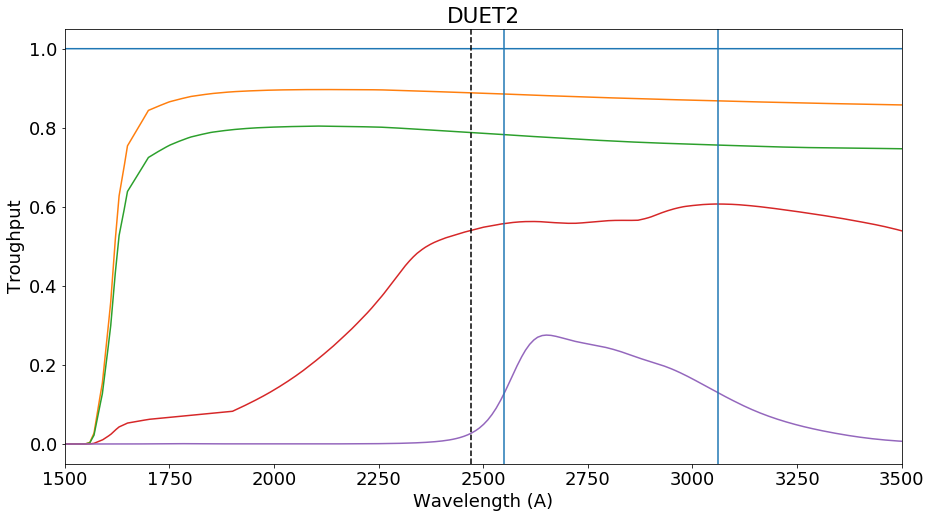

In [27]:
with quantity_support():
    plt.plot(flat['wavelength'], flat['flux'])
    plt.plot(flat['wavelength'], flat['flux_t'])
    plt.plot(flat['wavelength'], flat['flux_tr'])
    plt.plot(flat['wavelength'], flat['flux_trq2'])
    plt.plot(flat['wavelength'], flat['flux_trqf2'])
    
    plt.axvline(x=duet.bandpass2[0], ymin=0, ymax=1)
    plt.axvline(x=duet.bandpass2[1], ymin=0, ymax=1)
    
    plt.axvline(x=2470, ymin=0, ymax=1, color='black', linestyle='--')
    plt.xlim(1500, 3500)
    plt.title('DUET2')
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Troughput')
    plt.show()

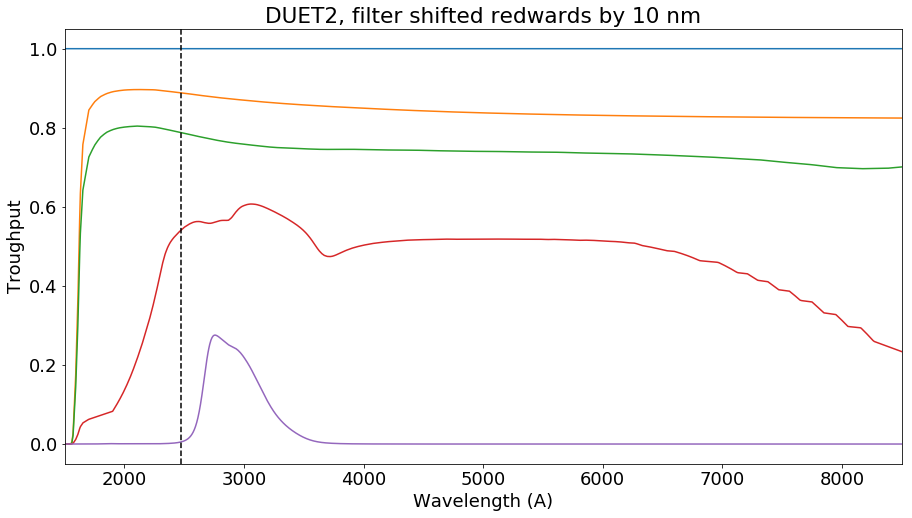

In [10]:
plt.plot(flat['wavelength'], flat['flux'])
plt.plot(flat['wavelength'], flat['flux_t'])
plt.plot(flat['wavelength'], flat['flux_tr'])
plt.plot(flat['wavelength'], flat['flux_trq2'])
plt.plot(flat['wavelength'], flat['flux_trqf2alt'])

plt.axvline(x=2470, ymin=0, ymax=1, color='black', linestyle='--')
plt.xlim(1500, 8500)
plt.title('DUET2, filter shifted redwards by 10 nm')
plt.xlabel('Wavelength (A)')
plt.ylabel('Troughput')
plt.show()

In [11]:
# Throughputs at [OII] line
print('Throughput at the [OII] line at 247 nm:')
print('DUET1:', flat['flux_trqf'][flat['wavelength'].value == 2470].value[0])
print()
print('DUET2 (standard):', flat['flux_trqf2'][flat['wavelength'].value == 2470].value[0])
print('DUET2 (shifted 10 nm):', flat['flux_trqf2alt'][flat['wavelength'].value == 2470].value[0])

Throughput at the [OII] line at 247 nm:
DUET1: 0.00389003281739907

DUET2 (standard): 0.026582505183103226
DUET2 (shifted 10 nm): 0.005066704251678104


In [12]:
# Background in all bands:
zodi['flux_t'] = apply_trans(zodi['wavelength'], zodi['flux'], trans_wave, transmission)
zodi['flux_tr'] = apply_trans(zodi['wavelength'], zodi['flux_t'], ref_wave, reflectivity)
zodi['flux_trq2'] = apply_trans(zodi['wavelength'], zodi['flux_tr'], qe_wave2, qe2)
zodi['flux_trqf2'] = apply_trans(zodi['wavelength'], zodi['flux_trq2'], red_wave2, red_trans2)
zodi['flux_trqf2alt'] = apply_trans(zodi['wavelength'], zodi['flux_trq2'], alt_wave2, alt_trans2)
zodi['flux_trq1'] = apply_trans(zodi['wavelength'], zodi['flux_tr'], qe_wave1, qe1)
zodi['flux_trqf1'] = apply_trans(zodi['wavelength'], zodi['flux_trq1'], red_wave1, red_trans1)

zodi_med['flux_t'] = apply_trans(zodi_med['wavelength'], zodi_med['flux'], trans_wave, transmission)
zodi_med['flux_tr'] = apply_trans(zodi_med['wavelength'], zodi_med['flux_t'], ref_wave, reflectivity)
zodi_med['flux_trq2'] = apply_trans(zodi_med['wavelength'], zodi_med['flux_tr'], qe_wave2, qe2)
zodi_med['flux_trqf2'] = apply_trans(zodi_med['wavelength'], zodi_med['flux_trq2'], red_wave2, red_trans2)
zodi_med['flux_trqf2alt'] = apply_trans(zodi_med['wavelength'], zodi_med['flux_trq2'], alt_wave2, alt_trans2)
zodi_med['flux_trq1'] = apply_trans(zodi_med['wavelength'], zodi_med['flux_tr'], qe_wave1, qe1)
zodi_med['flux_trqf1'] = apply_trans(zodi_med['wavelength'], zodi_med['flux_trq1'], red_wave1, red_trans1)

zodi_high['flux_t'] = apply_trans(zodi_high['wavelength'], zodi_high['flux'], trans_wave, transmission)
zodi_high['flux_tr'] = apply_trans(zodi_high['wavelength'], zodi_high['flux_t'], ref_wave, reflectivity)
zodi_high['flux_trq2'] = apply_trans(zodi_high['wavelength'], zodi_high['flux_tr'], qe_wave2, qe2)
zodi_high['flux_trqf2'] = apply_trans(zodi_high['wavelength'], zodi_high['flux_trq2'], red_wave2, red_trans2)
zodi_high['flux_trqf2alt'] = apply_trans(zodi_high['wavelength'], zodi_high['flux_trq2'], alt_wave2, alt_trans2)
zodi_high['flux_trq1'] = apply_trans(zodi_high['wavelength'], zodi_high['flux_tr'], qe_wave1, qe1)
zodi_high['flux_trqf1'] = apply_trans(zodi_high['wavelength'], zodi_high['flux_trq1'], red_wave1, red_trans1)

de = zodi['wavelength'][1] - zodi['wavelength'][0]

zodi['ph_flux1'] = (de*zodi['flux_trqf1']).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))
zodi_med['ph_flux1'] = (de*zodi_med['flux_trqf1']).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))
zodi_high['ph_flux1'] = (de*zodi_high['flux_trqf1']).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))

zodi['ph_flux2'] = (de*zodi['flux_trqf2']).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))
zodi_med['ph_flux2'] = (de*zodi_med['flux_trqf2']).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))
zodi_high['ph_flux2'] = (de*zodi_high['flux_trqf2']).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))

zodi['ph_flux2_alt'] = (de*zodi['flux_trqf2alt']).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))
zodi_med['ph_flux2_alt'] = (de*zodi_med['flux_trqf2alt']).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))
zodi_high['ph_flux2_alt'] = (de*zodi_high['flux_trqf2alt']).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))

bgd_band1_low = duet.fluence_to_rate(duet.pixel**2 * zodi['ph_flux1'].sum())
bgd_band1_med = duet.fluence_to_rate(duet.pixel**2 * zodi_med['ph_flux1'].sum())
bgd_band1_high = duet.fluence_to_rate(duet.pixel**2 * zodi_high['ph_flux1'].sum())
bgd_band1_o2 = duet.fluence_to_rate(duet.pixel**2 * np.max(zodi['ph_flux1']))

bgd_band2_low = duet.fluence_to_rate(duet.pixel**2 * zodi['ph_flux2'].sum())
bgd_band2_med = duet.fluence_to_rate(duet.pixel**2 * zodi_med['ph_flux2'].sum())
bgd_band2_high = duet.fluence_to_rate(duet.pixel**2 * zodi_high['ph_flux2'].sum())
bgd_band2_o2 = duet.fluence_to_rate(duet.pixel**2 * np.max(zodi['ph_flux2']))

bgd_alt2_low = duet.fluence_to_rate(duet.pixel**2 * zodi['ph_flux2_alt'].sum())
bgd_alt2_med = duet.fluence_to_rate(duet.pixel**2 * zodi_med['ph_flux2_alt'].sum())
bgd_alt2_high = duet.fluence_to_rate(duet.pixel**2 * zodi_high['ph_flux2_alt'].sum())
bgd_alt2_o2 = duet.fluence_to_rate(duet.pixel**2 * np.max(zodi['ph_flux2_alt']))

In [13]:
print('Total background rates for low, medium and high zodi:')
print()
print('Low zodi:')
print('DUET1:', bgd_band1_low)
print('DUET2 (standard):', bgd_band2_low)
print('DUET2 (shifted 10 nm):', bgd_alt2_low)
print()
print('Medium zodi:')
print('DUET1:', bgd_band1_med)
print('DUET2 (standard):', bgd_band2_med)
print('DUET2 (shifted 10 nm):', bgd_alt2_med)
print()
print('High zodi:')
print('DUET1:', bgd_band1_high)
print('DUET2 (standard):', bgd_band2_high)
print('DUET2 (shifted 10 nm):', bgd_alt2_high)
print()
print('Contribution from [OII] line:')
print('DUET1:', bgd_band1_o2)
print('DUET2 (standard):', bgd_band2_o2)
print('DUET2 (shifted 10 nm):', bgd_alt2_o2)

Total background rates for low, medium and high zodi:

Low zodi:
DUET1: 0.01753365098332382 ph / s
DUET2 (standard): 0.24715123657404042 ph / s
DUET2 (shifted 10 nm): 0.20960766107545592 ph / s

Medium zodi:
DUET1: 0.021059265735231956 ph / s
DUET2 (standard): 0.41265608399919357 ph / s
DUET2 (shifted 10 nm): 0.42700589879046763 ph / s

High zodi:
DUET1: 0.05050616167446476 ph / s
DUET2 (standard): 1.794997707379734 ph / s
DUET2 (shifted 10 nm): 2.2427752706147137 ph / s

Contribution from [OII] line:
DUET1: 0.014449238739669747 ph / s
DUET2 (standard): 0.10233804107700395 ph / s
DUET2 (shifted 10 nm): 0.019384874758239905 ph / s


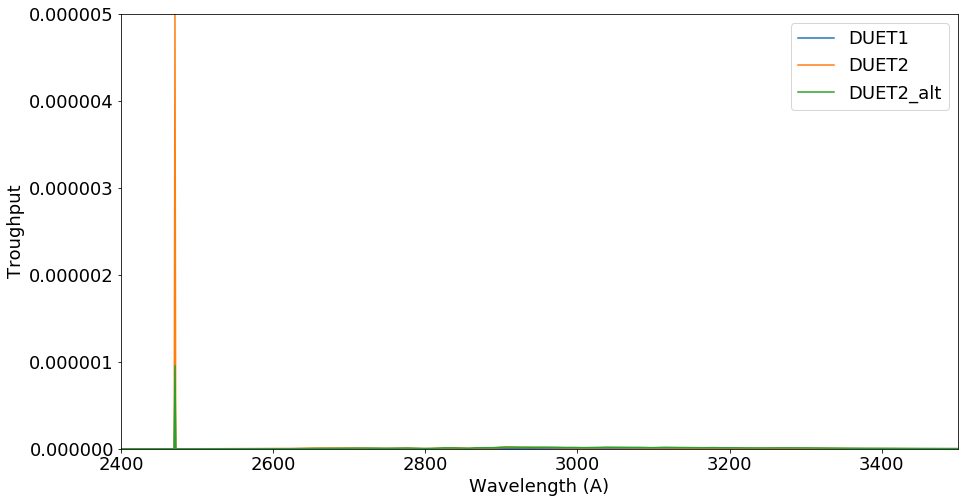

In [14]:
plt.plot(zodi['wavelength'], zodi['ph_flux1'], label='DUET1')
plt.plot(zodi['wavelength'], zodi['ph_flux2'], label='DUET2')
plt.plot(zodi['wavelength'], zodi['ph_flux2_alt'], label='DUET2_alt')

#plt.axvline(x=2470, ymin=0, ymax=1, color='black', linestyle='--')
plt.xlim(2400, 3500)
plt.ylim(0,5e-6)
plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Troughput')
plt.show()

In [18]:
# In-band vs out-of-band background: DUET1

bgd_band1_in_low = duet.fluence_to_rate(duet.pixel**2 * zodi['ph_flux1'][(zodi['wavelength'] >= duet.bandpass1[0]) & (zodi['wavelength'] <= duet.bandpass1[1])].sum())
bgd_band1_in_med = duet.fluence_to_rate(duet.pixel**2 * zodi_med['ph_flux1'][(zodi_med['wavelength'] >= duet.bandpass1[0]) & (zodi_med['wavelength'] <= duet.bandpass1[1])].sum())
bgd_band1_in_high = duet.fluence_to_rate(duet.pixel**2 * zodi_high['ph_flux1'][(zodi_high['wavelength'] >= duet.bandpass1[0]) & (zodi_high['wavelength'] <= duet.bandpass1[1])].sum())
# DUET2:
bgd_band2_in_low = duet.fluence_to_rate(duet.pixel**2 * zodi['ph_flux2'][(zodi['wavelength'] >= duet.bandpass2[0]) & (zodi['wavelength'] <= duet.bandpass2[1])].sum())
bgd_band2_in_med = duet.fluence_to_rate(duet.pixel**2 * zodi_med['ph_flux2'][(zodi_med['wavelength'] >= duet.bandpass2[0]) & (zodi_med['wavelength'] <= duet.bandpass2[1])].sum())
bgd_band2_in_high = duet.fluence_to_rate(duet.pixel**2 * zodi_high['ph_flux2'][(zodi_high['wavelength'] >= duet.bandpass2[0]) & (zodi_high['wavelength'] <= duet.bandpass2[1])].sum())



In [22]:
print('Backgrounds due to in-band zodiacal light:')
print('DUET1:')
print('Low zodi:', bgd_band1_in_low)
print('Medium zodi:', bgd_band1_in_med)
print('High zodi:', bgd_band1_in_high)
print()
print('DUET2:')
print('Low zodi:', bgd_band2_in_low)
print('Medium zodi:', bgd_band2_in_med)
print('High zodi:', bgd_band2_in_high)
print()
print('As fraction of total background:')
print('DUET1:')
print('Low zodi:', bgd_band1_in_low/(bgd_band1_low-bgd_band1_o2))
print('Medium zodi:', bgd_band1_in_med/(bgd_band1_med-bgd_band1_o2))
print('High zodi:', bgd_band1_in_high/(bgd_band1_high-bgd_band1_o2))
print()
print('DUET2:')
print('Low zodi:', bgd_band2_in_low/(bgd_band2_low-bgd_band2_o2))
print('Medium zodi:', bgd_band2_in_med/(bgd_band2_med-bgd_band2_o2))
print('High zodi:', bgd_band2_in_high/(bgd_band2_high-bgd_band2_o2))

Backgrounds due to in-band zodiacal light:
DUET1:
Low zodi: 0.001364778151616413 ph / s
Medium zodi: 0.0029245246106066 ph / s
High zodi: 0.01595195242149055 ph / s

DUET2:
Low zodi: 0.09031854354457831 ph / s
Medium zodi: 0.19353973616695355 ph / s
High zodi: 1.055671288183383 ph / s

As fraction of total background:
DUET1:
Low zodi: 0.44247592208996483
Medium zodi: 0.4424376197812877
High zodi: 0.44241025365192427

DUET2:
Low zodi: 0.6236900113596805
Medium zodi: 0.6236818663344125
High zodi: 0.62367604616543


In [43]:
# Average throughput out-of-band
through_band1_outofband = np.average(flat['flux_trqf'][(flat['wavelength'] <= duet.bandpass1[0]) | (flat['wavelength'] >= duet.bandpass1[1])])
through_band2_outofband = np.average(flat['flux_trqf2'][(flat['wavelength'] <= duet.bandpass2[0]) | (flat['wavelength'] >= duet.bandpass2[1])])

through_band1_redofband = np.average(flat['flux_trqf'][flat['wavelength'] >= duet.bandpass1[1]])
through_band2_redofband = np.average(flat['flux_trqf2'][flat['wavelength'] >= duet.bandpass2[1]])

through_band1_outofband2 = np.average(flat['flux_trqf'][(flat['wavelength'] <= duet.bandpass1[0]) | (flat['wavelength'] >= duet.bandpass1[1]) & (flat['wavelength'] <= 10000*u.angstrom)])
through_band2_outofband2 = np.average(flat['flux_trqf2'][(flat['wavelength'] <= duet.bandpass2[0]) | (flat['wavelength'] >= duet.bandpass2[1]) & (flat['wavelength'] <= 10000*u.angstrom)])


In [44]:
print('Average out-of-band throughput:')
print('DUET1:', through_band1_outofband.value)
print('DUET2:', through_band2_outofband.value)
print()
print('Average out-of-band throughput, redwards:')
print('DUET1:', through_band1_redofband.value)
print('DUET2:', through_band2_redofband.value)
print()
print('Average out-of-band throughput, truncated at 10000 A:')
print('DUET1:', through_band1_outofband2.value)
print('DUET2:', through_band2_outofband2.value)

Average out-of-band throughput:
DUET1: 0.0008686921572816013
DUET2: 0.0011666409352914355

Average out-of-band throughput, redwards:
DUET1: 0.0005926479254137417
DUET2: 0.0009397155811897913

Average out-of-band throughput, truncated at 10000 A:
DUET1: 0.002602479063622247
DUET2: 0.003551798002310198


In [65]:
# Sky background in ABmag/arcsec**2:
zodimag_low_1 = (zodi['ph_flux1'].sum()*u.arcsec**2/duet.band1['eff_width']).to(u.ABmag, equivalencies=u.spectral_density(duet.band1['eff_wave'].to(u.AA)))
zodimag_low_2 = (zodi['ph_flux2'].sum()*u.arcsec**2/duet.band2['eff_width']).to(u.ABmag, equivalencies=u.spectral_density(duet.band2['eff_wave'].to(u.AA)))

zodimag_med_1 = (zodi_med['ph_flux1'].sum()*u.arcsec**2/duet.band1['eff_width']).to(u.ABmag, equivalencies=u.spectral_density(duet.band1['eff_wave'].to(u.AA)))
zodimag_med_2 = (zodi_med['ph_flux2'].sum()*u.arcsec**2/duet.band2['eff_width']).to(u.ABmag, equivalencies=u.spectral_density(duet.band2['eff_wave'].to(u.AA)))

zodimag_high_1 = (zodi_high['ph_flux1'].sum()*u.arcsec**2/duet.band1['eff_width']).to(u.ABmag, equivalencies=u.spectral_density(duet.band1['eff_wave'].to(u.AA)))
zodimag_high_2 = (zodi_high['ph_flux2'].sum()*u.arcsec**2/duet.band2['eff_width']).to(u.ABmag, equivalencies=u.spectral_density(duet.band2['eff_wave'].to(u.AA)))

In [64]:
print('Brightness of background in ABmag/arcsec^2 (including [OII] emission):')
print('DUET1:')
print('Low zodi:', zodimag_low_1)
print('Medium zodi:', zodimag_med_1)
print('High zodi:', zodimag_high_1)
print()
print('DUET2:')
print('Low zodi:', zodimag_low_2)
print('Medium zodi:', zodimag_med_2)
print('High zodi:', zodimag_high_2)

Brightness of background in ABmag/arcsec^2 (including [OII] emission):
DUET1:
Low zodi: 29.98877531342191 mag(AB)
Medium zodi: 29.78984814515912 mag(AB)
High zodi: 28.840095295491178 mag(AB)

DUET2:
Low zodi: 27.28683043685168 mag(AB)
Medium zodi: 26.730266774836878 mag(AB)
High zodi: 25.134077660576438 mag(AB)
